In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
from sklearn.model_selection import train_test_split
#import algopy
#from algopy import UTPM, exp
import copy
import calendar
#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [2]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    
    def __init__(self, address, raw = False, dwd_data = True):
        if raw:
            self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        else:
            self.phen_data = pd.read_csv(address)
        ## CONVERT DATE TO DATETIME ##
        if dwd_data:
            self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
            self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
            self.add_locations()
        self.phase_list = [] #list of phases to consider
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False
        self.first_input_array = True

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            try:
                self.phen_data = self.phen_data.drop(drop_name, axis = 1)
            except:
                print(f'Column {drop_name} not found')
                continue
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = dataset_fctns.get_phase_name(phaseid, self.phase_names)
        self.order_phen_dataset()

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        self.phen_data = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #LAT, LON = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #self.phen_data['lat'] = LAT
        #self.phen_data['lon'] = LON
        #self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def index_time_from_emergence_day(self):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(366)])
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_driver_data = self.GDD_driver_data.sel(time=time_indexer, method='nearest')

    def align_emergence_obs_with_driver_data(self):
        ## Make sure we are comparing to observations where we have the driver data;
        #1. Align the times - need to check as it might run for some days then go off the end.
        #self.just_emergence = self.just_emergence.where(self.just_emergence['Referenzjahr'] <= 2024)
        ## Make sure all elements are in the driver data
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Eintrittsdatum'] + np.timedelta64(12, 'h'), self.GDD_driver_data['time'])]
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Stations_id'], self.GDD_driver_data['Stations_id'])]
        self.just_emergence = self.just_emergence.dropna()
    
    def get_unique_xy_station(self, x_coords, y_coords, station_ids):
        unique_values = np.unique(np.stack([x_coords, y_coords, station_ids]), axis = 1)
        return unique_values[0, :], unique_values[1, :], unique_values[2, :]

    def make_input_array(self, epsg_num = 3035, latlon_proj = False, start_year = 2001):
        self.latlon_proj = latlon_proj
        ## Puts pandas phenological frame into driver xarray and aligns the two
        #self.just_emergence = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        ## For now just do data after 2005 to save time
        if self.first_input_array:
            self.obs_for_GDD = self.phen_data.where(self.phen_data['Eintrittsdatum'] >= np.datetime64(f'{start_year}-01-01')).dropna()
            x_coords = self.obs_for_GDD['lon'].values
            y_coords = self.obs_for_GDD['lat'].values
            station_ids = np.int64(self.obs_for_GDD['Stations_id'].values)
            x_unique, y_unique, stations = self.get_unique_xy_station(x_coords, y_coords, station_ids)
            #Makes an array to put into GDD model
            print('project to new coords')
            self.stations = stations
            if not(latlon_proj):
                x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_unique, y_unique, epsg_num = epsg_num)
                self.x_driver_proj = x_epsg
                self.y_driver_proj = y_epsg
            else:
                self.x_driver_proj = x_unique
                self.y_driver_proj = y_unique
            print('interpolate driver to station locations')
            # Working in xarray (not pandas) after this point:
            #print('Latlonproj:', not(latlon_proj))
            self.GDD_driver_data = dataset_fctns.interpolate_xy(self.x_driver_proj, self.y_driver_proj, self.T_mean, xy=not(latlon_proj))
            self.GDD_driver_data = self.GDD_driver_data.assign_coords(Stations_id=("modelpoint", self.stations))
            if not(latlon_proj):
                self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
            self.first_input_array = False
        else: 
            new_GDD_driver_data = dataset_fctns.interpolate_xy(self.x_driver_proj, self.y_driver_proj, self.T_mean, xy=not(latlon_proj))
            new_GDD_driver_data = new_GDD_driver_data.assign_coords(Stations_id=("modelpoint", self.stations))
            if not(latlon_proj):
                new_GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
            new_GDD_driver_data = new_GDD_driver_data.set_xindex(['Stations_id'])
            self.GDD_driver_data = xr.concat([self.GDD_driver_data, new_GDD_driver_data], dim='time')
            self.GDD_driver_data = self.GDD_driver_data.sortby('time')

    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        self.obs_for_GDD = self.obs_for_GDD.where(self.obs_for_GDD['Referenzjahr'] <= 2023)
        ## Make the indexer to extract things at the right time.
        #self.align_emergence_obs_with_driver_data()
        self.obs_for_GDD = dataset_fctns.add_SOS_to_df(self.obs_for_GDD)
        self.obs_for_GDD['WC SOS date'] = pd.to_datetime(self.obs_for_GDD['Referenzjahr'], format='%Y') + pd.to_timedelta(self.obs_for_GDD['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.obs_for_GDD[['Stations_id', 'WC SOS date']])
        time_station = time_station.rename({'index':'Emergence observation', 'WC SOS date':'time'})
        if not(self.latlon_proj):
            time_station['time'] += np.timedelta64(12, 'h')
        ## Initiate development time storage object.
        t_dev = np.zeros(time_station.sizes['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        try:
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        except:
            print('Couldn\'t reset index for station')
        #Run model
        for day in range(300):
            #print(day)
            driver_values = self.GDD_driver_data.sel(time_station)[driver_variable].values 
            t_dev += response(driver_values, t_dev)
            dev_time_series.append(t_dev.copy())
            time_station['time'] += np.timedelta64(1, 'D')
        dev_time_series.append(self.obs_for_GDD['Eintrittsdatum'].values.astype('datetime64[Y]'))
        dev_time_series.append(self.obs_for_GDD['Stations_id'].values)
        self.model_dev_time_series = np.array(dev_time_series)
        self.GDD_driver_data['Development Time'] = (('days from emergence', 'Emergence observation'), self.model_dev_time_series)

    def get_phase_dates(self, thresholds):
        column_names = np.concatenate([np.array(thresholds), ['Referenzjahr'], ['Stations_id']])
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:-2, obs_index].astype(np.float64))
        self.phase_dates_array = np.concatenate([self.phase_dates_array, [pd.to_datetime(self.model_dev_time_series[-2]).year], [self.model_dev_time_series[-1]]], axis=0)
        self.phase_dates_array = pd.DataFrame(self.phase_dates_array.T, columns = column_names)
        self.phase_dates_array.set_index(['Referenzjahr', 'Stations_id'])
        self.phase_dates_calculated = True
        
        #Note that the thresholds are NOT the bins for numpy digitize!
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, winter_sowing = False, count_from_SOS = True, pd_SOS = False):
        if pd_SOS:
            SOS_name = 'Planting date'
        else:
            SOS_name = 'WC SOS date'
        if count_from_SOS:
            self.phen_data = dataset_fctns.add_SOS_to_df(self.phen_data)
            self.ds_observed = self.phen_data[['Stations_id', 'Referenzjahr', 'lat', 'lon', 'SOS']].drop_duplicates()
            if pd_SOS:
                just_phase = self.phen_data.loc[self.phen_data['Name of phase'] == 'beginning of tilling sowing drilling']
                self.ds_observed = self.ds_observed.merge(just_phase[['Eintrittsdatum', 'Referenzjahr', 'Stations_id']], how = 'left', on = ['Referenzjahr', 'Stations_id']).rename(columns={'Eintrittsdatum': SOS_name})
            else:
                self.phen_data[SOS_name] = pd.to_datetime(self.phen_data['Referenzjahr'], format='%Y') + pd.to_timedelta(self.phen_data['SOS'], 'D')
                self.ds_observed[SOS_name] = pd.to_datetime(self.ds_observed['Referenzjahr'], format='%Y') + pd.to_timedelta(self.ds_observed['SOS'], 'D')
            for phase in self.phase_list:
                just_phase = self.phen_data.loc[self.phen_data['Name of phase'] == phase]
                just_phase= just_phase.assign(**{f'observed time to {phase}': just_phase['Eintrittsdatum']})
                self.ds_observed = self.ds_observed.merge(just_phase[[f'observed time to {phase}', 'Referenzjahr', 'Stations_id']], how = 'left', on = ['Referenzjahr', 'Stations_id'])
                self.ds_observed[f'observed time to {phase}'] = self.ds_observed[f'observed time to {phase}'] - self.ds_observed[SOS_name]
        else:
            observed_to_first_stage = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', self.phase_list[0], winter_sowing=winter_sowing).dropna()
            self.ds_observed = pd.DataFrame({f'observed time to {self.phase_list[0]}': observed_to_first_stage})
            for phase in self.phase_list[1:]:
                self.ds_observed[f'observed time to {phase}'] = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase, winter_sowing=winter_sowing).dropna()
            self.ds_observed = self.ds_observed.reset_index()
            self.ds_observed = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
            self.ds_observed = self.ds_observed.merge(self.obs_for_GDD[['Eintrittsdatum', 'Referenzjahr', 'Stations_id']], how = 'outer', on=['Referenzjahr', 'Stations_id']).rename(columns={'Eintrittsdatum':'emergence date'})
        #self.ds_observed = self.ds_observed.set_index(['Referenzjahr', 'Stations_id'])
        #self.ds_observed = pd.concat([self.just_emergence.set_index(['Referenzjahr', 'Stations_id'], inplace=False)['Eintrittsdatum'], self.ds_observed], axis=1).rename(columns={'Eintrittsdatum':'emergence date'})
        #LAT, LON = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        #self.ds_observed['lat'] = LAT
        #self.ds_observed['lon'] = LON
        #self.ds_observed['lat'] = self.ds_observed['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.ds_observed['lon'] = self.ds_observed['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.merge(self.ds_observed, self.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])

    def get_X_y_for_ML2(self, driver_variable = 't2m', start_year = 2001, end_year = 2025, drop_columns = ['number', 'lon', 'lat', 'observation'], SOS_name = 'WC SOS date'):
        self.observations_to_use = self.ds_observed[['Stations_id', 'Referenzjahr', SOS_name]].where((self.ds_observed['Referenzjahr'] >= start_year)*(self.ds_observed['Referenzjahr'] <= end_year)).dropna().drop_duplicates()
        self.observations_to_use  = self.observations_to_use.loc[self.observations_to_use[SOS_name].dt.year == self.observations_to_use['Referenzjahr']]
        # make an indexing array to pull values from the array of temperatures
        time_station = xr.Dataset.from_dataframe(self.observations_to_use)
        time_station = time_station.rename({'index':'observation', SOS_name:'time'})
        #print(time_station)
        if not(self.latlon_proj):
            time_station['time'] += np.timedelta64(12, 'h')# - np.timedelta64(60, 'D')

        ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
        t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        try:
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        except:
            print('Couldn\'t reset index for station')
        
        #Run model
        first = True
        for day in range(310):
            # Pull values for temperature out of data frame
            print(day)
            driver_values = self.GDD_driver_data.sel(time_station[['Stations_id', 'time']])#[driver_variable]#.values 
            driver_frame_at_day = driver_values[[driver_variable, 'Stations_id', 'time']].to_pandas().reset_index().drop(drop_columns, axis=1)
            if first:
                years = driver_frame_at_day['time'].dt.year
                first = False
            driver_frame_at_day['Referenzjahr'] = years 
            driver_frame_at_day = driver_frame_at_day.drop('time', axis=1)
            driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'{driver_variable} at day {day}'})
            self.observations_to_use = self.observations_to_use.merge(driver_frame_at_day, on=['Referenzjahr', 'Stations_id'])
            time_station['time'] += np.timedelta64(1, 'D')
        self.driver_frame_for_ML = self.observations_to_use.merge(self.ds_observed[['Referenzjahr', 'Stations_id'] + [f'observed time to {phase}' for phase in self.phase_list]]).drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])

    def get_X_y_for_ML(self, driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2020, end_year = 2023):
        self.just_emergence = dataset_fctns.add_EOS_to_df(self.just_emergence)
        self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
        self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
        self.just_emergence['SOS'] = pd.to_timedelta(self.just_emergence['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'SOS']].drop_duplicates()) #, 'Referenzjahr'
        time_station = time_station.set_coords('Stations_id').set_xindex(['Stations_id'])
        time_station = time_station.drop_vars('index')
        time_station = time_station.expand_dims(dim={'time':pd.to_timedelta(np.arange(0, predictor_days), 'D')})
        time_station = time_station.expand_dims(dim={'Referenzjahr':pd.date_range(f'{start_year}-01-01', periods = end_year - start_year, freq='YS')})
        time_station['SOS'] = time_station['SOS'] + time_station['Referenzjahr'] + time_station['time'] 
        if not(self.latlon_proj):
            time_station['SOS'] += pd.Timedelta(12, 'h')
        time_station = time_station.rename({'time':'time_from_SOS', 'SOS':'time'})
        time_station = time_station.reset_index('Stations_id').reset_coords(names = 'Stations_id')
        self.time_station = time_station
        self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
        self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
        self.driver_data_for_ML = self.driver_data_for_ML.set_xindex(['Stations_id'])
        self.driver_data_for_ML['Referenzjahr'] = pd.to_datetime(self.driver_data_for_ML['Referenzjahr']).year
        self.driver_frame_for_ML = self.driver_data_for_ML.to_dataframe(dim_order = ['Referenzjahr', 'Stations_id', 'time_from_SOS'])
        self.driver_frame_for_ML = pd.concat([self.driver_frame_for_ML[driver_variable].unstack(),
                                            self.driver_frame_for_ML['lat'].unstack()['0 days'].rename('lat'),
                                            self.driver_frame_for_ML['lon'].unstack()['0 days'].rename('lon'),
                                            self.driver_frame_for_ML['time'].unstack()['0 days'].rename('WC SOS')], axis=1)
        self.driver_frame_for_ML.rename(columns={self.driver_frame_for_ML.columns[x]: f'{driver_variable} day {x}' for x in range(200)}, inplace=True)
        self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML.reset_index(), self.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)
        if self.phase_dates_calculated:
            self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML, self.phase_dates_array.reset_index(), how='left', on=['Referenzjahr', 'Stations_id'])

    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.GDD_driver_data['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, md=20):
        self.regr = tree.DecisionTreeRegressor(max_depth=md, min_samples_leaf=5)
        self.fit = self.regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(self.phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = self.fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = self.fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_predictions_training = self.ds_ML_predictions_training.drop_duplicates()
        self.ds_ML_predictions_verification = self.ds_ML_predictions_verification.drop_duplicates()
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results, self.ds_comparison, self.ds_observed], axis = 1)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1812\3442820026.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [31]:
Maize_set.T_mean

<xarray.Dataset> Size: 5GB
Dimensions:             (time: 25568, bnds: 2, y: 220, x: 240)
Coordinates:
  * time                (time) datetime64[ns] 205kB 1951-01-01T12:00:00 ... 2...
    lon                 (y, x) float64 422kB ...
    lat                 (y, x) float64 422kB ...
  * x                   (x) float32 960B 3.502e+06 3.508e+06 ... 4.698e+06
  * y                   (y) float32 880B 2.102e+06 2.108e+06 ... 3.198e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 409kB ...
    x_bnds              (x, bnds) float32 2kB ...
    y_bnds              (y, bnds) float32 2kB ...
    crs_HYRAS           int32 4B ...
    tas                 (time, y, x) float32 5GB ...
    number_of_stations  (time) float64 205kB ...
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

In [142]:
def prepare_African_phen_ds(ds, phase, reducer = 'mean'):
    ds['yrcode'] = ds[f'observed time to {phase}'].dt.year
    ds.loc[:, 'first season'] = 1
    columns_to_keep = ['lat', 'lon', 'Stations_id', f'observed time to {phase}', 'yrcode', 'first season', 'SOS', 'EOS', 'SOS2', 'EOS2']
    if np.isin('PlantingDate', ds.columns):
        print('yes')
        columns_to_keep.append('PlantingDate')
    locs = ds[['Stations_id', 'yrcode', 'lat', 'lon']].drop_duplicates()
    for row in locs.T:
        yr1 = ds.loc[(ds['Stations_id'] == locs.loc[row, 'Stations_id'])*(ds['yrcode'] == locs.loc[row, 'yrcode'])]
        if (yr1['PlantingDate'].max() - yr1['PlantingDate'].min()).days > 40:
            second_season = ((yr1['PlantingDate'] - yr1['PlantingDate'].min()) > np.timedelta64(40, 'D'))*((yr1['PlantingDate'] - yr1['PlantingDate'].min()) < np.timedelta64(250, 'D'))
            season_2_indices = second_season[second_season].index
            #print(season_2_indices)
            #print(((yr1['PlantingDate'] - yr1['PlantingDate'].min()).days > 40)*((yr1['PlantingDate'] - yr1['PlantingDate'].min()).days < 250)).dt.days
            ds.loc[season_2_indices, 'first season'] = 0
            #print(ds.loc[((yr1['PlantingDate'] - yr1['PlantingDate'].min()).days > 40)*((yr1['PlantingDate'] - yr1['PlantingDate'].min()).days < 250), 'first season'])
    if reducer == 'mean':
        ds = ds[columns_to_keep].groupby(['Stations_id', 'yrcode', 'first season', 'lat', 'lon']).mean().reset_index()
    elif reducer == 'max':
        ds = ds[columns_to_keep].groupby(['Stations_id', 'yrcode', 'first season', 'lat', 'lon']).max().reset_index()
    ds = dataset_fctns.WC_date_from_columns(ds, phase)
    return ds

In [143]:
phen_data_CIMMYT = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')
phen_data_CIMMYT = dataset_fctns.columns_to_datetime(phen_data_CIMMYT, ['PlantingDate', 'AnthesisDate', 'DaysToSilk'])
phen_data_CIMMYT = phen_data_CIMMYT.rename(columns={'AnthesisDate': 'observed time to beginning of flowering'})


In [148]:
phen_data_CIMMYT = dataset_fctns.prepare_African_phen_ds(phen_data_CIMMYT, 'beginning of flowering', reducer = 'max')#'PlantingDate', 
phen_data_CIMMYT = phen_data_CIMMYT.loc[(phen_data_CIMMYT['observed time to beginning of flowering'] - phen_data_CIMMYT['WC SOS date']).dt.days < 240]
phen_data_CIMMYT['WC SOS date'] = phen_data_CIMMYT['PlantingDate']
phen_data_CIMMYT['Referenzjahr'] = phen_data_CIMMYT['yrcode']

yes


In [150]:
phen_data_CIMMYT['time to flowering'] = phen_data_CIMMYT['observed time to beginning of flowering'] - phen_data_CIMMYT['PlantingDate']

<Axes: xlabel='time to flowering', ylabel='Count'>

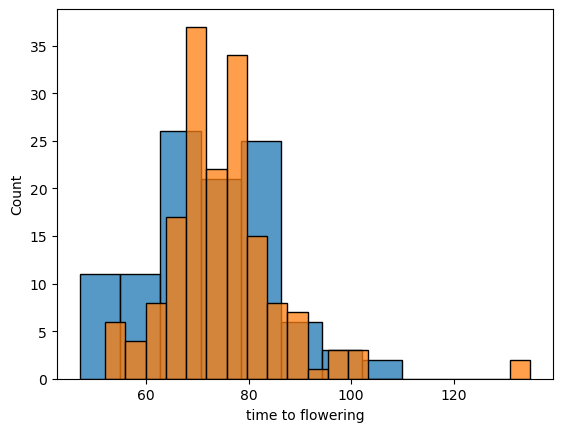

In [156]:
fig, ax = plt.subplots()
sns.histplot(phen_data_CIMMYT.loc[phen_data_CIMMYT['PlantingDate'].dt.dayofyear < 150]['time to flowering'].dt.days, ax=ax)
sns.histplot(phen_data_CIMMYT.loc[phen_data_CIMMYT['PlantingDate'].dt.dayofyear >= 150]['time to flowering'].dt.days, ax=ax)

In [146]:
phen_data_CIMMYT.loc[phen_data_CIMMYT['first season'] == 0]

,Stations_id,yrcode,first season,lat,lon,observed time to beginning of flowering,SOS,EOS,SOS2,EOS2,PlantingDate,WC SOS date,Referenzjahr
19,15,2003.0,0,-9.1000,13.7000,2003-08-22 09:36:00,260,159,46,167,2003-06-18,2003-06-18,2003.0
79,530,2001.0,0,-13.1300,34.0700,2001-08-25 07:12:00,260,159,46,167,2001-06-02,2001-06-02,2001.0
81,530,2003.0,0,-13.1300,34.0700,2003-08-16 16:48:00,260,159,46,167,2003-05-22,2003-05-22,2003.0
83,530,2004.0,0,-13.1300,34.0700,2004-08-06 12:00:00,260,159,46,167,2004-05-15,2004-05-15,2004.0
149,904,2006.0,0,-3.3658,36.6745,2006-08-07 16:48:00,260,159,46,167,2006-05-15,2006-05-15,2006.0
151,905,2001.0,0,-3.1800,36.7000,2001-09-15 02:24:00,260,159,46,167,2001-05-28,2001-05-28,2001.0
153,905,2003.0,0,-3.1800,36.7000,2003-09-11 12:00:00,260,159,46,167,2003-05-31,2003-05-31,2003.0
155,905,2004.0,0,-3.1800,36.7000,2004-08-25 16:48:00,260,159,46,167,2004-06-07,2004-06-07,2004.0
159,907,2001.0,0,-3.3600,36.6700,2001-09-03 21:36:00,260,159,46,167,2001-05-23,2001-05-23,2001.0
185,931,2004.0,0,-5.0700,32.7300,2004-04-06 00:00:00,260,159,46,167,2004-01-25,2004-01-25,2004.0


In [48]:
locs = phen_data_CIMMYT[['Stations_id', 'yrcode', 'lat', 'lon']].drop_duplicates()
for row in locs.T:
    print(row)
for ind in range(318):
    yr1 = phen_data_CIMMYT.loc[(phen_data_CIMMYT['Stations_id'] == locs.iloc[ind, 0])*(phen_data_CIMMYT['yrcode'] == locs.iloc[ind, 1])]
    #print((yr1['observed time to beginning of flowering'].max() - yr1['observed time to beginning of flowering'].min()).days)
    if (yr1['PlantingDate'].max() - yr1['PlantingDate'].min()).days > 40:
        print('hmm PD', yr1['observed time to beginning of flowering'].max() - yr1['PlantingDate'].max())
        #fig, ax = plt.subplots()
        #sns.histplot(yr1['PlantingDate'], ax=ax)
    if (yr1['observed time to beginning of flowering'].max() - yr1['observed time to beginning of flowering'].min()).days > 40:
        print('hmm')
    #elif np.isnan((yr1['observed time to beginning of flowering'].max() - yr1['observed time to beginning of flowering'].min()).days):
    #    print(yr1)

0
121
211
297
332
406
458
460
488
621
673
697
749
774
806
927
955
1197
1965
2086
2092
2152
2641
2775
2907
3214
3334
3466
3532
3599
3600
3841
3850
3910
4580
4682
4769
4866
4914
4966
4967
5052
5107
5228
5263
5316
5482
5483
5643
5691
5790
5962
6083
6085
6145
6377
6521
6556
6611
6760
6783
6915
7012
7146
7174
7197
7318
7346
7478
7642
7718
7750
7929
8045
8119
8205
8233
8342
8440
8513
8517
8858
8979
9108
9184
9250
9316
9351
9376
9504
9532
9574
9708
9810
9927
10048
10051
10079
10265
10300
10355
10476
10481
10537
10795
10862
10892
10968
10973
11181
11283
11350
11467
11543
11545
11727
11777
11809
11871
11992
12059
12135
12165
12200
12563
12855
13123
13155
13276
13386
13453
13481
13509
13630
13635
13893
14027
14094
14211
14287
14292
14610
14677
14753
14758
14790
15048
15152
15219
15269
15390
15511
15516
15664
15731
15973
15979
16239
16507
16574
16650
16655
16835
16870
16943
17064
17198
17259
17283
17352
17354
17494
17542
17574
17636
17705
17706
17754
17774
17806
17868
17937
17938
18030
18092
1816

In [58]:
phen_data_CIMMYT.loc[phen_data_CIMMYT['first season'] == 0]

,Stations_id,yrcode,first season,lat,lon,observed time to beginning of flowering,SOS,EOS,SOS2,EOS2,PlantingDate,WC SOS date,Referenzjahr


In [5]:
phen_data_CIMMYT = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')
phen_data_CIMMYT = dataset_fctns.columns_to_datetime(phen_data_CIMMYT, ['PlantingDate', 'AnthesisDate', 'DaysToSilk'])
phen_data_CIMMYT = phen_data_CIMMYT.rename(columns={'AnthesisDate': 'observed time to beginning of flowering'})
phen_data_CIMMYT = dataset_fctns.prepare_African_phen_ds(phen_data_CIMMYT, 'beginning of flowering', reducer = 'max')#'PlantingDate', 
phen_data_CIMMYT = phen_data_CIMMYT.loc[(phen_data_CIMMYT['observed time to beginning of flowering'] - phen_data_CIMMYT['WC SOS date']).dt.days < 240]
phen_data_CIMMYT['WC SOS date'] = phen_data_CIMMYT['PlantingDate']
phen_data_CIMMYT['Referenzjahr'] = phen_data_CIMMYT['yrcode']

yes


In [4]:
#phen_data_CIMMYT = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')

In [6]:
Maize_set_Africa = Phenology_set('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\maizedata.lobell.sep2011.csv', raw = False, dwd_data=False)
Maize_set_Africa.phen_data = phen_data_CIMMYT
Maize_set_Africa.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Africa\\ERA5_SSA_1999_2009.nc')
Maize_set_Africa.phen_data['Eintrittsdatum'] = Maize_set_Africa.phen_data['PlantingDate']
#Maize_set_Africa.phen_data['Stations_id'] = Maize_set_Africa.phen_data['sitecode']
Maize_set_Africa.make_input_array(latlon_proj=True, start_year = 1999)

project to new coords
interpolate driver to station locations


In [112]:
#Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt", raw = True)
Maize_set = Phenology_set('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv', raw = False)
Maize_set.drop_columns(['Unnamed: 9', 'Unnamed: 0'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])

Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2011_2024.nc') #'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')#
Maize_set.make_input_array(latlon_proj=True)
#Maize_set.GDD_driver_data = Maize_set.GDD_driver_data.where(Maize_set.GDD_driver_data['time'] >= np.datetime64('2012-01-01'), drop = True)
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2001_2010.nc')
Maize_set.make_input_array(latlon_proj=True)
Maize_set.phase_list = ['beginning of flowering', 'beginning of tilling sowing drilling'] #['beginning of emergence', 'beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset(pd_SOS = True)

Column Unnamed: 9 not found
project to new coords
interpolate driver to station locations


In [106]:
def get_X_y_for_ML2(self, driver_variable = 't2m', start_year = 2001, end_year = 2025, drop_columns = ['number', 'lon', 'lat', 'observation'], SOS_name = 'WC SOS date', numdays = 220):
    self.observations_to_use = self.ds_observed[['Stations_id', 'Referenzjahr', SOS_name]].where((self.ds_observed['Referenzjahr'] >= start_year)*(self.ds_observed['Referenzjahr'] <= end_year)).dropna().drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])
    #print(self.observations_to_use, self.observations_to_use.drop_duplicates(subset = ['Stations_id', 'Planting date']))
    self.observations_to_use  = self.observations_to_use.loc[self.observations_to_use[SOS_name].dt.year == self.observations_to_use['Referenzjahr']]
    # make an indexing array to pull values from the array of temperatures
    time_station = xr.Dataset.from_dataframe(self.observations_to_use)
    time_station = time_station.rename({'index':'observation', SOS_name:'time'})
    #print(time_station)
    if not(self.latlon_proj):
        time_station['time'] += np.timedelta64(12, 'h')# - np.timedelta64(60, 'D')

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    try:
        self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
    except:
        print('Couldn\'t reset index for station')
    #print(time_station)
    #print(time_station[['observation', 'time']].drop_duplicates('observation'))
    #Run model
    first = True
    for day in range(310):
        # Pull values for temperature out of data frame
        print(day)
        driver_values = self.GDD_driver_data.sel(time_station[['Stations_id', 'time']])#[driver_variable]#.values 
        driver_frame_at_day = driver_values[[driver_variable, 'Stations_id', 'time']].to_pandas().reset_index().drop(drop_columns, axis=1)
        if first:
            years = driver_frame_at_day['time'].dt.year
            first = False
        driver_frame_at_day['Referenzjahr'] = years #driver_frame_at_day['time'].dt.year
        #driver_frame_at_day.loc[driver_frame_at_day['time'].dt.dayofyear < 80, 'Referenzjahr'] = driver_frame_at_day.loc[driver_frame_at_day['time'].dt.dayofyear < 50, 'time'] .dt.year - 1
        #print(driver_frame_at_day)
        driver_frame_at_day = driver_frame_at_day.drop('time', axis=1)
        driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'{driver_variable} at day {day}'})
        #print(driver_frame_at_day)
        #print(driver_frame_at_day.drop_duplicates(subset = ['Referenzjahr', 'Stations_id']))
        print(len(self.observations_to_use))
        self.observations_to_use = self.observations_to_use.merge(driver_frame_at_day, on=['Referenzjahr', 'Stations_id']).dropna()
        time_station['time'] += np.timedelta64(1, 'D')
    self.driver_frame_for_ML = self.observations_to_use.merge(self.ds_observed[['Referenzjahr', 'Stations_id'] + [f'observed time to {phase}' for phase in self.phase_list]]).drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])
    return self

In [63]:
SOS_name = 'Planting date'
start_year = 2011
end_year = 2024
Maize_set.observations_to_use = Maize_set.ds_observed[['Stations_id', 'Referenzjahr', SOS_name]].where((Maize_set.ds_observed['Referenzjahr'] >= start_year)*(Maize_set.ds_observed['Referenzjahr'] <= end_year)).dropna().drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])

In [64]:
Maize_set.observations_to_use.loc[Maize_set.observations_to_use['Planting date'].dt.year != Maize_set.observations_to_use['Referenzjahr']]

,Stations_id,Referenzjahr,Planting date
7530,8104.0,2018.0,2017-04-10
30006,10117.0,2018.0,2017-04-28
37907,10593.0,2018.0,2017-04-18
63511,12294.0,2018.0,2017-04-23


In [113]:
#Maize_set_Africa.ds_observed = Maize_set_Africa.phen_data
Maize_set.get_X_y_for_ML2(driver_variable = 't2m', SOS_name = 'Planting date')#, start_year = 2001, end_year = 2019, drop_columns=['lon', 'lat', 'observation', 'x', 'y'])


Couldn't reset index for station
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
2

In [114]:
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_ERA5_pd_SOS.csv')

In [5]:
stat_locs = Maize_set.ds_observed.where(Maize_set.ds_observed['Referenzjahr'] >=2000).dropna()
stat_locs = stat_locs[['lat', 'lon', 'Stations_id']].drop_duplicates()

In [8]:
np.savetxt("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\station_coords_MODIS.csv",
        stat_locs.values,
        delimiter =", ",
        fmt ='% s')

In [37]:
pd.to_datetime(phen_data_after_97['WC SOS date']).dt.date

1      2004-02-20
2      2003-12-07
3      2005-01-19
4      2003-12-15
5      2005-01-25
          ...    
281    2002-11-29
282    2002-11-29
283    2005-12-16
284    2002-11-29
289    2004-12-24
Name: WC SOS date, Length: 271, dtype: object

In [8]:
def put_temp_values_in_frame(driver_array, ds_observed, driver_variable, latlon_proj = True, phase_list = ['yellow ripeness'], SOS_offset = 0, station_locations = False):
    observations_to_use = ds_observed[['Stations_id', 'Referenzjahr', 'WC SOS date']].where(ds_observed['Referenzjahr'] > 1999).dropna(how='all').drop_duplicates()
    observations_to_use['WC SOS date'] += np.timedelta64(SOS_offset, 'D')
    observations_to_use['SOS_year'] = observations_to_use['WC SOS date'].dt.year
    observations_to_use['WC SOS date'] = pd.to_datetime(observations_to_use['WC SOS date'].dt.date)
    observations_to_use = observations_to_use.drop_duplicates(subset = ['SOS_year', 'Stations_id'])
    # make an indexing array to pull values from the array of temperatures
    time_station = xr.Dataset.from_dataframe(observations_to_use)
    time_station = time_station.rename({'index':'observation', 'WC SOS date':'time'})
    #print(time_station)
    if not(latlon_proj):
        time_station['time'] += np.timedelta64(12, 'h')
    #print(time_station['time'].min())
    time_vals = time_station['time'].values
    #print(time_vals[~np.isin(time_vals, driver_array['time'].values)])
    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    try:
        driver_array = driver_array.set_xindex(['Stations_id'])
    except:
        print('Couldn\'t reset index for station')
    
    #Run model
    for day in range(300):
        print(day)
        # Pull values for temperature out of data frame
        driver_values = driver_array.sel(time_station[['Stations_id', 'time']])#[driver_variable]#.values 
        #print('sel function applied')
        driver_frame_at_day = driver_values[[driver_variable, 'Stations_id', 'time']].to_pandas().reset_index().drop(['number', 'lon', 'lat', 'observation'], axis=1)
        #print('converted to pandas frame')
        if day == 0:
            SOS_years = driver_frame_at_day['time'].dt.year
            
            #Referenzjahrs = driver_frame_at_day['time'].dt.year + (driver_frame_at_day['time'].dt.dayofyear > 180)
        driver_frame_at_day['SOS_year'] = SOS_years #driver_frame_at_day['time'].dt.year
        #print(driver_frame_at_day)
        driver_frame_at_day = driver_frame_at_day.drop('time', axis=1)
        driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'temperature at day {day}'})
        #print(len(observations_to_use[['SOS_year', 'Stations_id']]), len(observations_to_use[['SOS_year', 'Stations_id']].drop_duplicates()),
        #    len(driver_frame_at_day[['SOS_year', 'Stations_id']]), len(driver_frame_at_day[['SOS_year', 'Stations_id']].drop_duplicates()))
        observations_to_use = observations_to_use.merge(driver_frame_at_day, on=['SOS_year', 'Stations_id'], how='inner')
        #print(observations_to_use)
        #print('merged')
        time_station['time'] += np.timedelta64(1, 'D')
    ds = observations_to_use.merge(ds_observed[['Referenzjahr', 'Stations_id'] + [f'observed time to {phase}' for phase in phase_list]]).drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])
    #return ds
    ds = ds.dropna(subset = ['temperature at day 0'] + [f'observed time to {phase}' for phase in phase_list]).drop_duplicates()#
    ds[[f'observed time to {phase}' for phase in phase_list]] = ds[[f'observed time to {phase}' for phase in phase_list]] + np.timedelta64(-SOS_offset, 'D')
    if type(station_locations) != bool:
        ds = get_station_locations(ds, station_locations)
    return ds#, observations_to_use, driver_frame_at_day

In [23]:
def get_X_y_for_ML2(self, driver_variable = 't2m', start_year = 2001, end_year = 2025, drop_columns = ['number', 'lon', 'lat', 'observation']):
    self.observations_to_use = self.ds_observed[['Stations_id', 'Referenzjahr', 'WC SOS date']].where((self.ds_observed['Referenzjahr'] >= start_year)*(self.ds_observed['Referenzjahr'] <= end_year)).dropna().drop_duplicates()
    # make an indexing array to pull values from the array of temperatures
    time_station = xr.Dataset.from_dataframe(self.observations_to_use)
    time_station = time_station.rename({'index':'observation', 'WC SOS date':'time'})
    #print(time_station)
    if not(self.latlon_proj):
        time_station['time'] += np.timedelta64(12, 'h')# - np.timedelta64(60, 'D')

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    try:
        self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
    except:
        print('Couldn\'t reset index for station')
    
    #Run model
    for day in range(310):
        # Pull values for temperature out of data frame
        print(day)
        driver_values = self.GDD_driver_data.sel(time_station[['Stations_id', 'time']])#[driver_variable]#.values 
        driver_frame_at_day = driver_values[[driver_variable, 'Stations_id', 'time']].to_pandas().reset_index().drop(drop_columns, axis=1)
        driver_frame_at_day['Referenzjahr'] = driver_frame_at_day['time'].dt.year
        driver_frame_at_day = driver_frame_at_day.drop('time', axis=1)
        driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'{driver_variable} at day {day}'})
        print(driver_frame_at_day.columns.to_list())
        self.observations_to_use = self.observations_to_use.merge(driver_frame_at_day, on=['Referenzjahr', 'Stations_id'])
        time_station['time'] += np.timedelta64(1, 'D')
    self.driver_frame_for_ML = self.observations_to_use.merge(self.ds_observed[['Referenzjahr', 'Stations_id'] + [f'observed time to {phase}' for phase in self.phase_list]]).drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])
    return self

In [25]:
Maize_set = get_X_y_for_ML2(Maize_set, driver_variable = 'tas', start_year = 2001, end_year = 2019, drop_columns=['lon', 'lat', 'observation', 'x', 'y'])

Couldn't reset index for station
0
['tas at day 0', 'Stations_id', 'Referenzjahr']
1
['tas at day 1', 'Stations_id', 'Referenzjahr']
2
['tas at day 2', 'Stations_id', 'Referenzjahr']
3
['tas at day 3', 'Stations_id', 'Referenzjahr']
4
['tas at day 4', 'Stations_id', 'Referenzjahr']
5
['tas at day 5', 'Stations_id', 'Referenzjahr']
6
['tas at day 6', 'Stations_id', 'Referenzjahr']
7
['tas at day 7', 'Stations_id', 'Referenzjahr']
8
['tas at day 8', 'Stations_id', 'Referenzjahr']
9
['tas at day 9', 'Stations_id', 'Referenzjahr']
10
['tas at day 10', 'Stations_id', 'Referenzjahr']
11
['tas at day 11', 'Stations_id', 'Referenzjahr']
12
['tas at day 12', 'Stations_id', 'Referenzjahr']
13
['tas at day 13', 'Stations_id', 'Referenzjahr']
14
['tas at day 14', 'Stations_id', 'Referenzjahr']
15
['tas at day 15', 'Stations_id', 'Referenzjahr']
16
['tas at day 16', 'Stations_id', 'Referenzjahr']
17
['tas at day 17', 'Stations_id', 'Referenzjahr']
18
['tas at day 18', 'Stations_id', 'Referenzjahr']

In [29]:
Maize_set.GDD_driver_data.dropna(dim='modelpoint')

<xarray.Dataset> Size: 54MB
Dimensions:             (time: 25568, modelpoint: 261)
Coordinates:
  * time                (time) datetime64[ns] 205kB 1951-01-01T12:00:00 ... 2...
    lon                 (modelpoint) float64 2kB 10.86 10.91 ... 14.63 14.6
    lat                 (modelpoint) float64 2kB 53.82 53.25 ... 51.95 51.43
    x                   (modelpoint) float64 2kB 4.055e+06 ... 4.309e+06
    y                   (modelpoint) float64 2kB 2.996e+06 ... 2.749e+06
  * Stations_id         (modelpoint) float64 2kB 1.443e+04 ... 1.094e+04
Dimensions without coordinates: modelpoint
Data variables:
    crs_HYRAS           int32 4B 1
    tas                 (time, modelpoint) float64 53MB -2.483 -2.712 ... 1.364
    number_of_stations  (time) float64 205kB 817.0 818.0 ... 1.454e+03 1.456e+03
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

In [13]:
driver_stats = phen_data_after_97['Stations_id']#Maize_set_Africa.GDD_driver_data['Stations_id'].values
driver_stats[~np.isin(driver_stats, Maize_set_Africa.GDD_driver_data['Stations_id'].values)]#phen_data_after_97['Stations_id'])]

21       16
23       18
43      464
58      501
59      507
102     536
103     536
135     875
136     878
138     881
158     913
169     921
170     922
182     953
195    1020
207    1024
208    1029
209    1031
230    1040
252    1048
279    1058
Name: Stations_id, dtype: int64

In [26]:
Maize_set_Africa.GDD_driver_data.time.max()

<xarray.DataArray 'time' ()> Size: 8B
array('2008-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    number   int64 8B 0

In [25]:
phen_data_after_97['WC SOS date'].max()

Timestamp('2007-12-27 00:00:00')

In [6]:
phen_data_after_97 = Maize_set_Africa.phen_data.loc[Maize_set_Africa.phen_data['WC SOS date'] >= np.datetime64('1999-01-01')]
ds = put_temp_values_in_frame(Maize_set_Africa.GDD_driver_data, phen_data_after_97, 't2m', phase_list = ['beginning of flowering'],
                               SOS_offset=0, station_locations=False)#, dad, otu 
#ds1 = ds1.dropna(subset = ['temperature at day 0', 'observed time to yellow ripeness']).drop_duplicates()#
ds['observed time to beginning of flowering'] = ds['observed time to beginning of flowering'] - ds['WC SOS date']
#ds = ds.where((ds['observed time to beginning of flowering'].dt.days > 0))# & (ds['observed time to beginning of flowering'].dt.days < 270)).dropna()
ds.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_Africa_t2m_PD_SOS2.csv')
#ds = ds1
#ds1 = put_ERA5_in_array(ds1)

Couldn't reset index for station
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
2

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

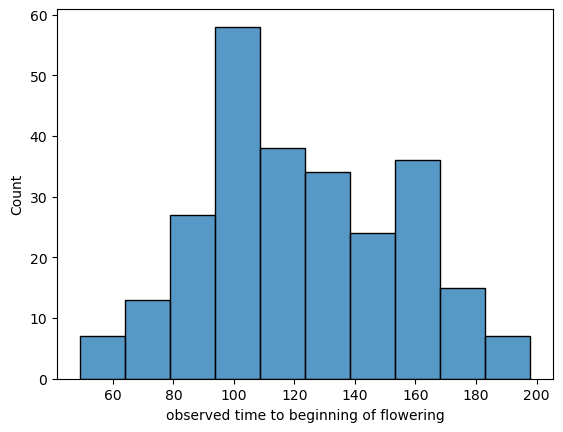

In [19]:
sns.histplot(ds['observed time to beginning of flowering'].dt.days)

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

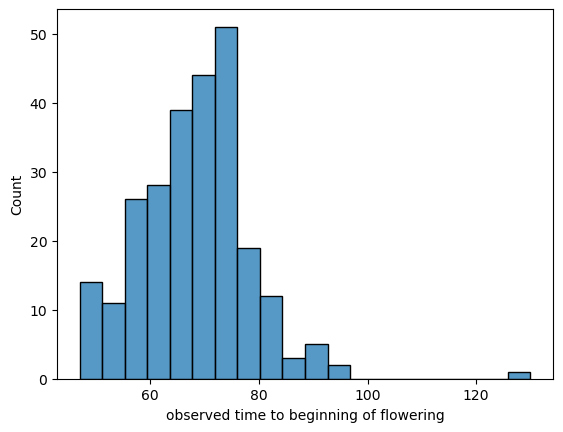

In [51]:
sns.histplot(ds['observed time to beginning of flowering'].dt.days)